In [1]:
# Cargamos las librerias necesarias para el desarrollo del ETL.
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [5]:
# Leemos los archivos csv.
df_reviews_wordcloud = pd.read_csv('./DATA/DATA PROCESADA/df_reviews_final.csv')
df_items_wordcolud = pd.read_csv('./DATA/DATA PROCESADA/df_items_final.csv')
df_games_wordcloud = pd.read_csv('./DATA/DATA PROCESADA/df_games_final.csv')


In [6]:
df_games_wordcloud['title'] = df_games_wordcloud['title'].astype(str)
df_items_wordcolud['item_name'] = df_items_wordcolud['item_name'].astype(str)

In [7]:
title = ' '.join(df_games_wordcloud['title'])
item_name = ' '.join(df_items_wordcolud['item_name'])

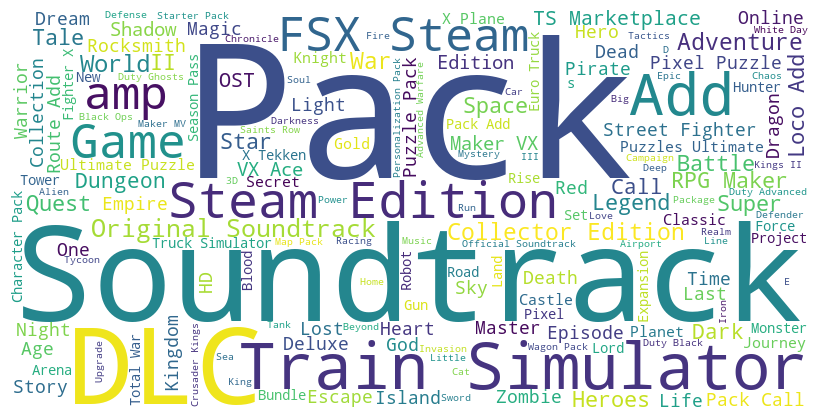

In [9]:
# Mostrar el wordcloud del titulo de los juegos.
word_cloud = WordCloud(width=800, height=400, background_color='white', min_font_size=10).generate(title)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

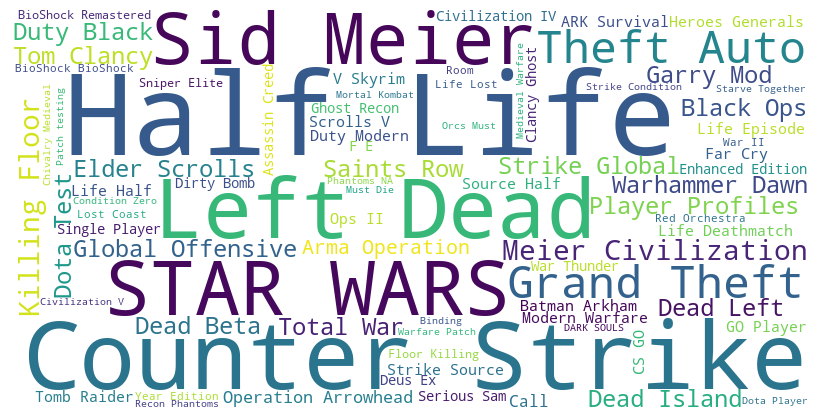

In [10]:
# Mostramos el wordcloud de los items.
word_cloud = WordCloud(width=800, height=400, background_color='white', min_font_size=10).generate(item_name)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()